In [ ]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# see py file
from utils import *

if os.path.exists("varunr.mplstyle"):
    plt.style.use("varunr.mplstyle")

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Basic Example

In [29]:
dgp = DataGenerationContinuousMetric(treatment_effect=0.1, y0_bias=0)
estimators = [
    ("naive", naive),
    ("cuped", cuped),
]
results_frame_basic = simulate(
    dgp, estimators=estimators, N_trials=1000, sample_size=10000
)
(
    results_frame_basic.groupby(by=["estimator"]).agg(
        mean=("effect_size", "mean"), stddev=("effect_size", "std")
    )
)

,mean,stddev
estimator,,
cuped,0.099907,0.019107
naive,0.099947,0.026958


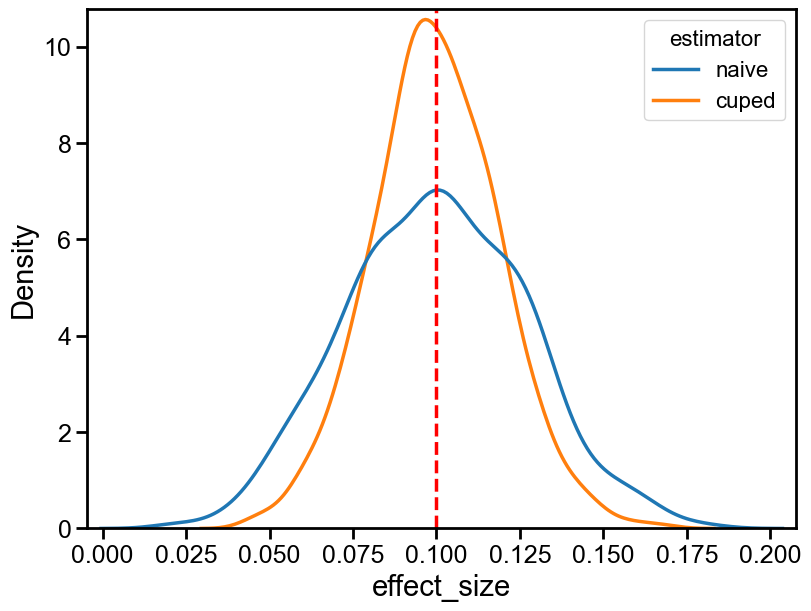

In [37]:
fig = plt.figure()
ax = fig.gca()
sns.kdeplot(ax=ax, data=results_frame_basic, x="effect_size", hue="estimator")
ax.axvline(x=0.1, linestyle="--", color="r")

## Pre-exposure bias

In [109]:
dgp = DataGenerationContinuousMetric(treatment_effect=1, y0_bias=1)
estimators = [
    ("naive", naive),
    ("CUPED", cuped),
    ("CUPED advanced", cuped_advanced),
]
results_frame_bias = simulate(
    dgp, estimators=estimators, N_trials=1000, sample_size=10000
)
(
    results_frame_bias.groupby(by=["estimator"]).agg(
        mean=("effect_size", "mean"), stddev=("effect_size", "std")
    )
)

,mean,stddev
estimator,,
CUPED,0.799375,0.018824
CUPED advanced,0.999265,0.021510
naive,1.999947,0.026958


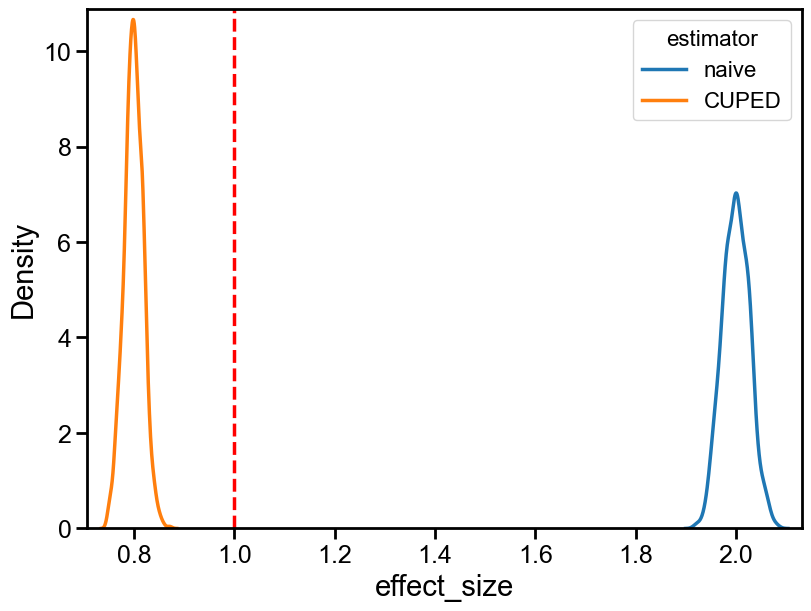

In [ ]:
fig = plt.figure()
ax = fig.gca()
sns.kdeplot(
    ax=ax,
    data=results_frame_bias.query("estimator != 'CUPED advanced'"),
    x="effect_size",
    hue="estimator",
)
ax.axvline(x=1, linestyle="--", color="r")

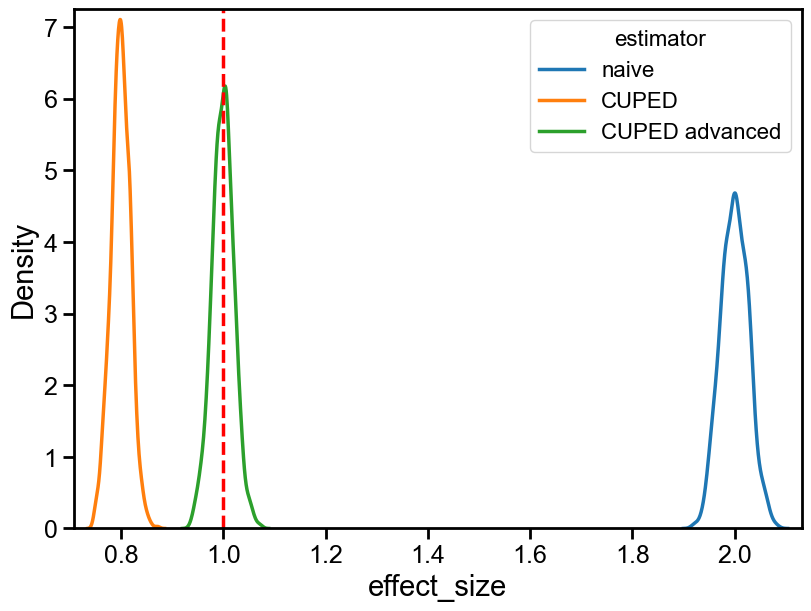

In [113]:
fig = plt.figure()
ax = fig.gca()
sns.kdeplot(ax=ax, data=results_frame_bias, x="effect_size", hue="estimator")
ax.axvline(x=1, linestyle="--", color="r")

## Winsorization/Binarization

In [ ]:
dgp = DataGenerationContinuousMetric(treatment_effect=0.1, y0_noise_dist="lognormal")
estimators = [
    ("naive", naive),
    ("CUPED", cuped),
]
estimators_binary = estimators + [("CUPED binary", cuped_binary)]
results_frame_original = simulate(
    dgp, estimators=estimators, N_trials=1000, sample_size=10000
)
results_frame_winsorize = simulate(
    dgp, estimators=estimators, N_trials=1000, sample_size=10000, winsorize_q=0.95
)
results_frame_binarize = simulate(
    dgp, estimators=estimators_binary, N_trials=1000, sample_size=10000, binarize_q=0.5
)

In [ ]:
results_frame_all = pd.concat(
    (
        results_frame_original.assign(dataset="original"),
        results_frame_winsorize.assign(dataset="winsorize"),
        results_frame_binarize.assign(dataset="binarize"),
    ),
    axis="rows",
    ignore_index=True,
)

results_frame_agg = (
    results_frame_all.groupby(by=["dataset", "estimator"])
    .agg(mean=("effect_size", "mean"), stddev=("effect_size", "std"))
    .reset_index()
    .assign(z=lambda x: x["mean"] / x["stddev"])
)

variance_reduction_frame = (
    results_frame_agg.pivot_table(index="dataset", columns="estimator", values="stddev")
    .assign(variance_reduction=lambda x: 1 - (x["CUPED"] / x["naive"]) ** 2)
    .reset_index()
)
z_score_frame = results_frame_agg.query("estimator == 'CUPED'").merge(
    results_frame_agg.query("estimator == 'naive'"),
    on=["dataset"],
    suffixes=("_cuped", "_naive"),
)
variance_reduction_frame[["dataset", "variance_reduction"]].merge(
    z_score_frame[["z_cuped", "z_naive", "dataset"]], on=["dataset"]
)

,dataset,variance_reduction,z_cuped,z_naive
0,binarize,0.160240,3.141850,2.877969
1,original,0.829457,5.230095,2.157303
2,winsorize,0.474875,4.073825,2.949498


In [92]:
results_frame_agg

,dataset,estimator,mean,stddev,z
0,binarize,CUPED,0.027291,0.008686,3.141850
1,binarize,CUPED binary,0.027333,0.007744,3.529786
2,binarize,naive,0.027280,0.009479,2.877969
3,original,CUPED,0.099908,0.019103,5.230095
4,original,naive,0.099790,0.046257,2.157303
5,winsorize,CUPED,0.094587,0.023218,4.073825
6,winsorize,naive,0.094503,0.032040,2.949498


### Closer look at binarized results

In [ ]:
s = (
    results_frame_binarize.groupby(by=["estimator"])
    .agg(mean=("effect_size", "mean"), stddev=("effect_size", "std"))
    .reset_index()
    .assign(z=lambda x: x["mean"] / x["stddev"])
)
(
    s.assign(dummy=True)
    .merge(
        s.query("estimator == 'naive'").assign(dummy=True),
        on=["dummy"],
        suffixes=("", "_naive"),
    )
    .assign(variance_reduction=lambda x: 1 - (x["stddev"] / x["stddev_naive"]) ** 2)
)

,estimator,mean,stddev,z,dummy,estimator_naive,mean_naive,stddev_naive,z_naive,variance_reduction
0,CUPED,0.027291,0.008686,3.141850,True,naive,0.02728,0.009479,2.877969,0.160240
1,CUPED binary,0.027333,0.007744,3.529786,True,naive,0.02728,0.009479,2.877969,0.332616
2,naive,0.027280,0.009479,2.877969,True,naive,0.02728,0.009479,2.877969,0.000000


<Axes: xlabel='effect_size', ylabel='Density'>

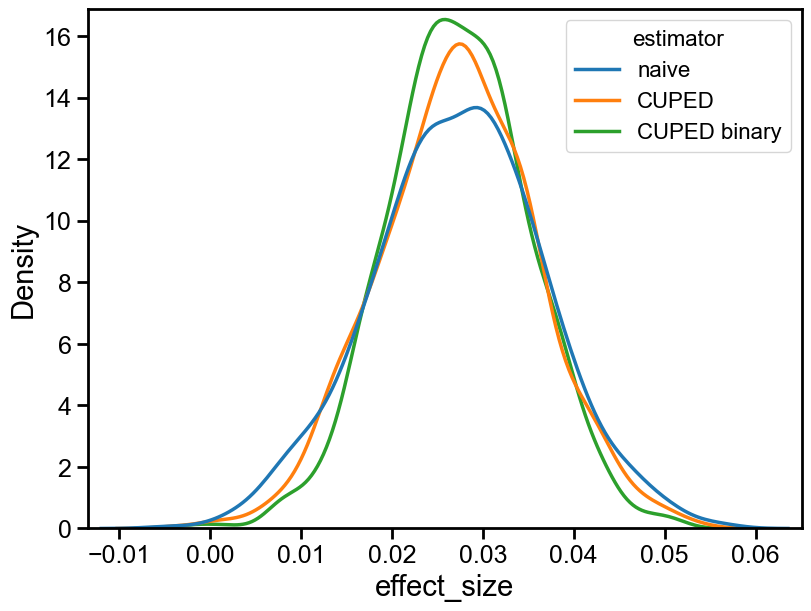

In [ ]:
sns.kdeplot(
    results_frame_all.query("dataset == 'binarize'"), x="effect_size", hue="estimator"
)